In [ ]:
import os, pickle, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import timedelta

# -------------------------------
# Config
# -------------------------------
models_dir = os.path.join('..', 'models')
model_file = os.path.join(models_dir, 'tsla_lstm_model.keras')
scaler_file = os.path.join(models_dir, 'tsla_lstm_scaler.pkl')
metadata_file = os.path.join(models_dir, 'tsla_lstm_metadata.json')

FORECAST_DAYS = 252    # ~12 months trading days
MC_SAMPLES = 50       # Monte Carlo runs for CI
USE_GPU = True

In [2]:
# -------------------------------
# Load model, scaler, and metadata
# -------------------------------
print("Loading model from:", model_file)
model = tf.keras.models.load_model(model_file)

with open(scaler_file, 'rb') as f:
    scaler = pickle.load(f)

with open(metadata_file, 'r') as f:
    metadata = json.load(f)

seq_length = metadata['sequence_length']
ticker = metadata['ticker']

print(f"Loaded LSTM model for {ticker}, trained on {metadata['start_date']} → {metadata['end_date']}")
print(f"Performance: MAE={metadata['mae']:.4f}, RMSE={metadata['rmse']:.4f}, MAPE={metadata['mape_percent']:.2f}%")

Loading model from: ..\models\tsla_lstm_model.keras
Loaded LSTM model for TSLA, trained on 2015-07-01 → 2025-07-31
Performance: MAE=9.0291, RMSE=12.5192, MAPE=3.26%


In [3]:
# -------------------------------
# Load historical data
# -------------------------------
import yfinance as yf
df = yf.download(ticker, start=metadata['start_date'], end=metadata['end_date'])
prices = df['Close'].dropna()
dates = prices.index

scaled_prices = scaler.transform(prices.values.reshape(-1, 1))

C:\Users\hp\AppData\Local\Temp\ipykernel_25024\1722424876.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=metadata['start_date'], end=metadata['end_date'])
[*********************100%***********************]  1 of 1 completed


In [ ]:
def predict_one_step(model, seq):
    """One-step prediction with dropout enabled for MC sampling."""
    return model(seq, training=True).numpy()

last_seq = scaled_prices[-seq_length:].reshape(1, seq_length, 1)
mc_forecasts = np.zeros((MC_SAMPLES, FORECAST_DAYS))

print(f"Running {MC_SAMPLES} Monte Carlo simulations for {FORECAST_DAYS} days...")
for m in range(MC_SAMPLES):
    seq = last_seq.copy()
    preds = []
    for step in range(FORECAST_DAYS):
        pred_scaled = predict_one_step(model, seq)
        preds.append(pred_scaled.ravel()[0])
        seq = np.append(seq[:, 1:, :], [[[pred_scaled.ravel()[0]]]], axis=1)
    mc_forecasts[m, :] = preds

# Convert back to USD
mc_forecasts_usd = scaler.inverse_transform(mc_forecasts.reshape(-1, 1)).reshape(MC_SAMPLES, FORECAST_DAYS)

forecast_mean = mc_forecasts_usd.mean(axis=0)
lower_ci = np.percentile(mc_forecasts_usd, 2.5, axis=0)
upper_ci = np.percentile(mc_forecasts_usd, 97.5, axis=0)

Running 200 Monte Carlo simulations for 252 days...


NameError: name 'forecast_mean' is not defined

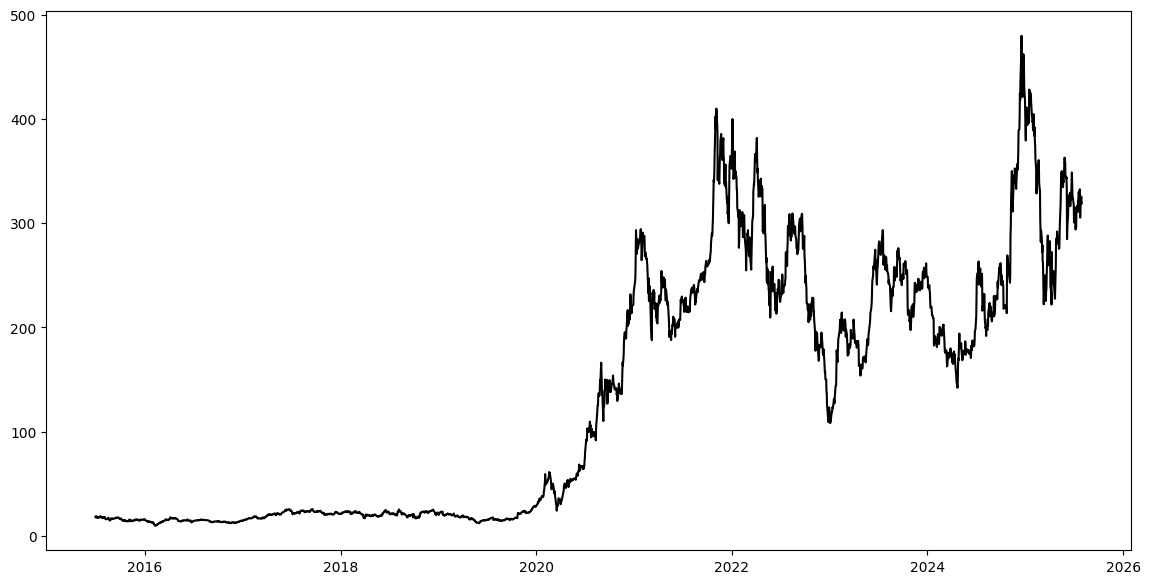

In [ ]:
# -------------------------------
# Create forecast dates
# -------------------------------
forecast_index = pd.bdate_range(start=dates[-1] + timedelta(days=1), periods=FORECAST_DAYS)

# -------------------------------
# Plot
# -------------------------------
plt.figure(figsize=(14, 7))
plt.plot(dates, prices.values, label='Historical', color='black')
plt.plot(forecast_index, forecast_mean, label='LSTM Forecast (mean)', color='orange')
plt.fill_between(forecast_index, lower_ci, upper_ci, color='orange', alpha=0.25, label='95% CI')
plt.title(f"{ticker} - {FORECAST_DAYS}-Day Forecast (MC Dropout)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# -------------------------------
# Quick diagnostics
# -------------------------------
last_price = prices.iloc[-1]
final_forecast_price = forecast_mean[-1]
trend = "upward" if final_forecast_price > last_price else "downward"
final_ci_width = upper_ci[-1] - lower_ci[-1]

print("--- Forecast Summary ---")
print(f"Last historical close: ${last_price:.2f}")
print(f"Final forecast mean: ${final_forecast_price:.2f} → Trend: {trend}")
print(f"95% CI width at final horizon: ${final_ci_width:.2f}")
print("CI widens over time, reflecting higher uncertainty for longer-term forecasts.")

NameError: name 'forecast_mean' is not defined

In [ ]:
# -------------------------------
# Save forecast results
# -------------------------------
forecast_df = pd.DataFrame({
    'date': forecast_index,
    'forecast_mean': forecast_mean,
    'lower_95': lower_ci,
    'upper_95': upper_ci
}).set_index('date')

forecast_csv = os.path.join(models_dir, 'tsla_lstm_forecast_mc_dropout.csv')
forecast_df.to_csv(forecast_csv)
print(f"Saved forecast data to: {forecast_csv}")